In [3]:
import os
import numpy as np
from glob import glob
from collections import defaultdict
import argparse
import pickle
import pandas as pd

def parse_filename(filename):
    base = os.path.basename(filename).replace(".npy", "")
    parts = base.split("_")
    if len(parts) < 5:
        raise ValueError(f"Unexpected filename format: {filename}")
    dv = parts[0]
    model = parts[2]
    size = int(parts[3])
    layer = parts[4]
    return dv, model, size, layer

def compute_stats(data):
    mean = np.mean(data)
    stderr = np.std(data, ddof=1) / np.sqrt(len(data))
    return mean, stderr

def get_df(log_dir="../encoding/logs/", dset='dorsal'):
    # Load the dataframe
    with open("../dataset/dorsal_stream_neuron_table.pickle", "rb") as f:
        df = pickle.load(f)
    # Load the dataframe
    with open("../dataset/dorsal_stream_dataset.pickle", "rb") as f:
        dataset = pickle.load(f)    
    
    files = glob(os.path.join(log_dir, "*_test.npy"))
    results = defaultdict(list)  # key: (model_disp, layer_disp) -> list of (size, mean, stderr)

    max_mean = -np.inf
    max_entry = (None, None, None, None)  # (mean, model_disp, layer_disp, size)
        
    for f in files:
        dv, model, size, layer = parse_filename(f)

        if dv == dset and model == 'r3d18' and size == 224:
            data = np.load(f) ** 2 # square corr to average for each neuron to compute r2
            uids = np.arange(len(data))
            new_df = pd.DataFrame({'neuron_uid': uids, f'r3d18_{layer}': data})
            df = pd.merge(df, new_df, left_on=['neuron_uid'], right_on=['neuron_uid'])
        elif dv == dset and 'simple3d' in model and 'res' not in model:
            layer = model[-1]
            data = np.load(f) ** 2 # square corr to average for each neuron to compute r2
            uids = np.arange(len(data))
            new_df = pd.DataFrame({'neuron_uid': uids, f'simple3d_{layer}': data})
            df = pd.merge(df, new_df, left_on=['neuron_uid'], right_on=['neuron_uid'])
            
    return df
df = get_df()

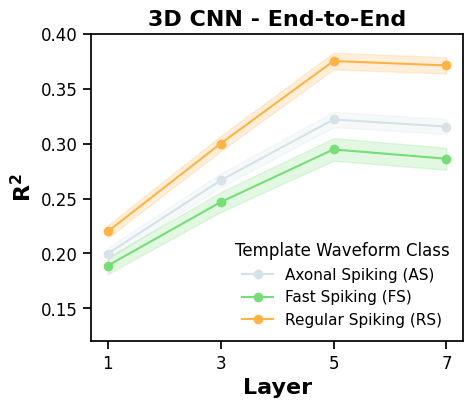

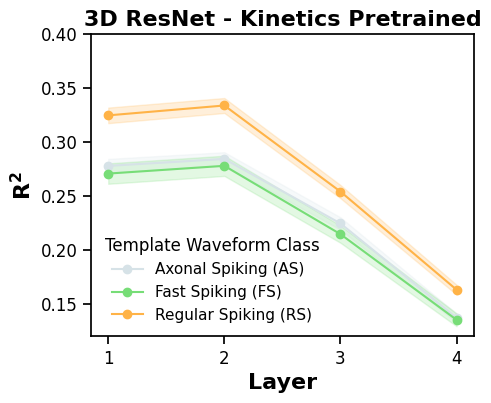

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set(style=None)
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.frameon': False,
})

def plot_performance_by_group(df, group_by='template_type', mod_name='simple3d', title=''):
    # Columns to extract model performance
    if mod_name == 'r3d18':
        perf_cols = ['r3d18_layer1', 'r3d18_layer2', 'r3d18_layer3', 'r3d18_layer4']
        layer_order = ['1', '2', '3', '4']
    elif mod_name == 'simple3d':
        perf_cols = ['simple3d_1', 'simple3d_3', 'simple3d_5', 'simple3d_7']
        layer_order = ['1', '3', '5', '7']

    # Melt the dataframe to long-form
    df_long = df.melt(
        id_vars=[group_by],
        value_vars=perf_cols,
        var_name='layer',
        value_name='performance'
    )
    # Clean up layer names
    if mod_name == 'r3d18':
        df_long['layer'] = df_long['layer'].str.replace('r3d18_layer', '')
    else:
        df_long['layer'] = df_long['layer'].str.replace('simple3d_', '')
        
    # Aggregate mean and sem
    summary = df_long.groupby([group_by, 'layer']).agg(
        mean_performance=('performance', 'mean'),
        sem=('performance', 'sem')
    ).reset_index()

    # Plotting
    color_map = {'FS': '#77DD77', 'RS': '#FFB347', 'AS': '#d6e2e7'}
    
    plt.figure(figsize=(5, 4))
    for name, group in summary.groupby(group_by):
        ct = name[-3:-1]

        x = group['layer']
        y = group['mean_performance']
        yerr = group['sem']

        # Convert layer labels to numeric sort order
        x_numeric = layer_order.index if isinstance(layer_order, list) else x

        # Plot the mean line
        plt.plot(x, y, label=str(name), marker='o', color=color_map[ct])

        # Add the shaded error region
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2, color=color_map[ct])

    plt.xlabel('Layer', fontsize=16, weight='bold')
    plt.ylabel('$\mathbf{{R^2}}$', fontsize=16, weight='bold')
    plt.xticks(ticks=layer_order, labels=layer_order)
    plt.legend(title=group_by, frameon=False)
    plt.tight_layout()
    plt.ylim([0.12, 0.4])
    plt.title(title, fontweight='bold', fontsize=16)
    plt.savefig(f"figures/{mod_name}.pdf", bbox_inches='tight')
    plt.show()

df['Template Waveform Class'] = df['template_type']
df.loc[df['Template Waveform Class'] == "AS", 'Template Waveform Class'] = "Axonal Spiking (AS)"
df.loc[df['Template Waveform Class'] == "FS", 'Template Waveform Class'] = "Fast Spiking (FS)"
df.loc[df['Template Waveform Class'] == "RS", 'Template Waveform Class'] = "Regular Spiking (RS)"

plot_performance_by_group(df, group_by='Template Waveform Class', mod_name ='simple3d', title="3D CNN - End-to-End")
plot_performance_by_group(df, group_by='Template Waveform Class', mod_name ='r3d18', title="3D ResNet - Kinetics Pretrained")

In [13]:
# sanity check - results agree with report in table
for model in ["simple3d_1", "simple3d_3", "simple3d_5", "simple3d_7", "r3d18_layer1", "r3d18_layer2", "r3d18_layer3", "r3d18_layer4"]:
    print(model)
    print('Grand avg:' + str(df[model].mean()))
    print('RS avg:' + str(df.loc[df['Template Waveform Class'] == "Regular Spiking (RS)", model].mean()))

simple3d_1
Grand avg:0.20557975750896118
RS avg:0.22004691439919008
simple3d_3
Grand avg:0.27580703920896643
RS avg:0.30019539138512835
simple3d_5
Grand avg:0.3375232588388106
RS avg:0.3753882991740043
simple3d_7
Grand avg:0.3316149457247316
RS avg:0.37133708375918734
r3d18_layer1
Grand avg:0.29491256744052646
RS avg:0.3247236127575556
r3d18_layer2
Grand avg:0.30257290100678175
RS avg:0.3338783377710041
r3d18_layer3
Grand avg:0.23414955348261685
RS avg:0.25405818065680735
r3d18_layer4
Grand avg:0.14690507840137443
RS avg:0.16310811350900395
